In [1]:
# ---------------------------
# 📦 Import Modeling Libraries
# ---------------------------
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

print("--- Cell 1: Libraries Imported ---")

--- Cell 1: Libraries Imported ---


In [2]:
# ---------------------------
# 📂 Cell 2: Load, Group, and Preprocess Data
# ---------------------------
print("\n--- Loading NEW Raw Dataset ---")
try:
    data = pd.read_csv("raw_student_data.csv")
    print("File 'raw_student_data.csv' loaded successfully.")
except FileNotFoundError:
    print("FATAL ERROR: 'raw_student_data.csv' not found. Run Cell 1 first.")

# ---------------------------
# 🧩 Group Similar Job Roles (THE CRITICAL STEP)
# ---------------------------
print("\n--- Grouping Text-Based Job Roles ---")
print(f"Original unique roles: {data['Job_Role'].unique()}")

data['Job_Role'] = data['Job_Role'].replace({
    # Group 1: Developers
    'Web Developer': 'Developer',
    'Frontend Developer': 'Developer',
    'Full Stack Developer': 'Developer',

    # Group 2: Data
    'Data Scientist': 'Data',
    'Data Analyst': 'Data',

    # Group 3: Management/QA
    'Business Analyst': 'Management/QA',
    'QA Tester': 'Management/QA'
})
print(f"NEW grouped roles: {data['Job_Role'].unique()}")

# ---------------------------
# 🔧 Preprocessing (The CORRECT Way for Mixed Data)
# ---------------------------
print("\n--- Full Preprocessing Pipeline ---")

# 1. Separate features (X) and target (y)
X = data.drop(['Student_ID', 'Job_Role'], axis=1)
y = data['Job_Role']

# 2. Identify numeric and categorical feature columns
numeric_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

print(f"Numeric features to scale: {list(numeric_cols)}")
print(f"Categorical features to encode: {list(categorical_cols)}")

# 3. Preprocess Features (X)
# --- Scale Numeric Features ---
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# --- One-Hot Encode Categorical Features ---
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print("\nFeatures have been scaled and one-hot encoded.")

# 4. Preprocess Target (y)
# --- Label Encode the Target Variable ---
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)

print("Target variable 'Job_Role' encoded.")
print(f"Encoding map: {list(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))}")

# ---------------------------
# ✂️ Train-Test Split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nData split: {X_train.shape[0]} train, {X_test.shape[0]} test.")


--- Loading NEW Raw Dataset ---
File 'raw_student_data.csv' loaded successfully.

--- Grouping Text-Based Job Roles ---
Original unique roles: ['Frontend Developer' 'Web Developer' 'Data Analyst' 'Data Scientist'
 'Full Stack Developer' 'QA Tester' 'Business Analyst']
NEW grouped roles: ['Developer' 'Data' 'Management/QA']

--- Full Preprocessing Pipeline ---
Numeric features to scale: ['CGPA', 'Aptitude_Score', 'Soft_Skills_Rating', 'Certifications_Count', 'Num_Projects']
Categorical features to encode: ['Gender', 'Stream']

Features have been scaled and one-hot encoded.
Target variable 'Job_Role' encoded.
Encoding map: [('Data', np.int64(0)), ('Developer', np.int64(1)), ('Management/QA', np.int64(2))]

Data split: 800 train, 200 test.


In [3]:
# ---------------------------
# 🤖 Cell 3: Train Individual Models
# ---------------------------
print("\n--- Training Individual Models ---")
models = {
    "Logistic Regression": LogisticRegression(max_iter=200, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred) * 100
    results.append({"Model": name, "Accuracy (%)": acc})

acc_df = pd.DataFrame(results).sort_values(by="Accuracy (%)", ascending=False)
print("\n📊 Individual Model Accuracies (in %):")
print(acc_df.to_string())


--- Training Individual Models ---

📊 Individual Model Accuracies (in %):
                 Model  Accuracy (%)
2        Random Forest          85.0
6    Gradient Boosting          81.5
3                  SVM          81.5
0  Logistic Regression          79.5
4                  KNN          79.0
5             AdaBoost          79.0
1        Decision Tree          77.5


In [4]:
# ---------------------------
# 🧠 Cell 4: Train Ensemble Model
# ---------------------------
print("\n--- Training Ensemble Model ---")
# Use the best performing models for the ensemble
voting_model = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(random_state=42)),
        ('gb', GradientBoostingClassifier(random_state=42)),
        ('svm', SVC(probability=True, random_state=42))
    ],
    voting='soft'
)

voting_model.fit(X_train, y_train)
y_pred_voting = voting_model.predict(X_test)
ensemble_acc = accuracy_score(y_test, y_pred_voting) * 100
print(f"\n🏆 Ensemble Model Accuracy: {ensemble_acc:.2f}%")


--- Training Ensemble Model ---

🏆 Ensemble Model Accuracy: 83.00%



--- Generating Accuracy Plot ---
Plot saved as new_model_accuracy_comparison.png


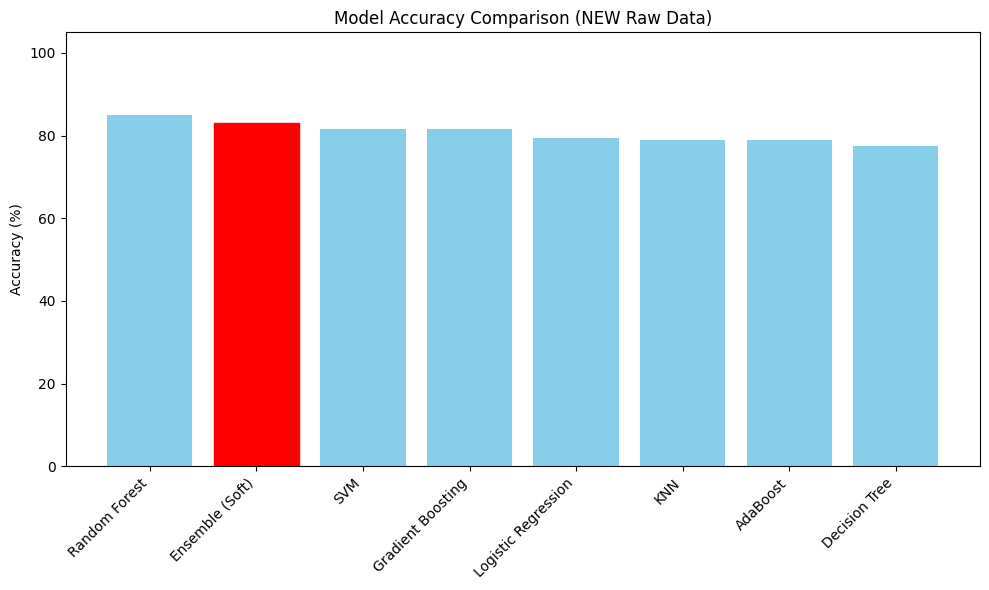

In [5]:
# ---------------------------
# 📊 Cell 5: Visualize Results
# ---------------------------
print("\n--- Generating Accuracy Plot ---")
ensemble_entry = pd.DataFrame([{"Model": "Ensemble (Soft)", "Accuracy (%)": ensemble_acc}])
plot_df = pd.concat([acc_df, ensemble_entry]).sort_values(by="Accuracy (%)", ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.bar(plot_df['Model'], plot_df['Accuracy (%)'], color='skyblue')

# Highlight the ensemble bar
for bar, model_name in zip(bars, plot_df['Model']):
    if 'Ensemble' in model_name:
        bar.set_color('red')

plt.title('Model Accuracy Comparison (NEW Raw Data)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 105) # Set y-limit to 105 for 100%
plt.tight_layout()

# Save the plot
plot_filename = "new_model_accuracy_comparison.png"
plt.savefig(plot_filename)
print(f"Plot saved as {plot_filename}")

# Show the plot in the notebook
plt.show()